In [1]:
import cv2
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data

import scipy.stats as ss

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm

from PIL import Image, ImageDraw, ImageFont
import PIL

import os

import copy
import random
import time

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('./data')

Drive already mounted at ./data; to attempt to forcibly remount, call drive.mount("./data", force_remount=True).


In [3]:
!cp /content/data/MyDrive/ColabNotebooks/Doc_recognition/Passports/pre_train.py /content
!cp /content/data/MyDrive/ColabNotebooks/Doc_recognition/Passports/models.py /content

In [10]:
import pre_train as pt
from models import CNNModelOneConv, CNNModelTwoConv

In [5]:
PREFIX = "data/MyDrive/ColabNotebooks/Doc_recognition/Passports/"

In [6]:
data = pd.read_csv(PREFIX + "dataset/Passports.csv")
data.head()

,Unnamed: 0,file_name,H,W,channels,dep,p_date,code,surname,name,...,b_place3-right-x,b_place3-right-y,up-left-x,up-left-y,up-right-x,up-right-y,bottom-left-x,bottom-left-y,bottom-right-x,bottom-right-y
0,0,passport0.jpg,731,522,3,ОТДЕЛОМ УФМС РОССИИ ПО КАЛУЖСКОЙ ОБЛ. В МАЛОЯР...,22.09.2014,400-017,ИЗМАЙЛОВ,РУСТАМ,...,470,615,22,430,168,430,22,618,168,618
1,1,passport1.jpg,731,522,3,ОКТЯБРЬСКИМ РУВД Г. ТАМБОВА,07.11.2018,682-016,ФИЛАТОВ,ПЛАТОН,...,470,615,22,430,168,430,22,618,168,618
2,2,passport2.jpg,731,522,3,ГУ МВД РОССИИ ПО РОСТОВСКОЙ ОБЛ.,01.01.2022,610-030,ТАРАСОВ,АЛЬБЕРТ,...,470,615,22,430,168,430,22,618,168,618
3,3,passport3.jpg,731,522,3,ОВД ДИГОРСКОГО РАЙОНА РЕСП. СЕВЕРНАЯ ОСЕТИЯ-АЛ...,05.07.2017,152-007,ФИЛАТОВ,КИРИЛЛ,...,470,615,22,430,168,430,22,618,168,618
4,4,passport4.jpg,731,522,3,УСПЕНСКИМ ПОСЕЛКОВЫМ ОМ ОДИНЦОВСКОГО РАЙОНА МО...,26.12.2019,503-068,КАРПОВ,ВЛАДИМИР,...,470,615,22,430,168,430,22,618,168,618


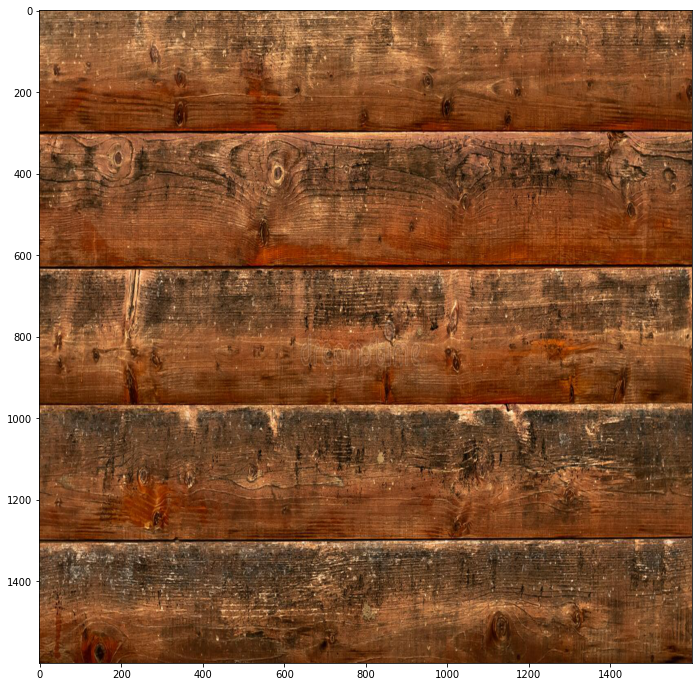

In [7]:
backgrounds = os.listdir(PREFIX + "photo_data/backgrounds")
backs = []

for bg in backgrounds:
    backs.append(PIL.Image.open(PREFIX + "photo_data/backgrounds/" + bg))
    size_0 = backs[-1].size

    backs[-1] = backs[-1].resize((size_0[0], size_0[0]))

ind = np.random.randint(len(backgrounds))
plt.figure(figsize=(12, 12))
plt.imshow(backs[ind])

In [8]:
images = os.listdir(PREFIX + "dataset/images")
np.random.shuffle(images)

RATIO = 0.9
train_inds = np.array([900])
valid_inds = np.array([901, 1000])

# Теперь попробуем что-нибудь обучить

## 1 convolution layer VS 2 convlution layers

In [11]:
Models = [CNNModelOneConv, CNNModelTwoConv]
Info = []
OUTPUT_DIM = 61
EPOCHS = 50

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model1 = Models[0](OUTPUT_DIM)
Info.append({"Loss": [], "L1": [], "Time": [], "Parameters": 0})
Info[-1]["Parameters"] = pt.count_parameters(model1)

optimizer = optim.Adam(params=model1.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

best_valid_loss = float('inf')

train_gen = pt.Generator(n_classes=61, batch_size=32, PREFIX=PREFIX)
valid_gen = pt.Generator(n_classes=61, batch_size=32, PREFIX=PREFIX)

for epoch in range(EPOCHS):


    start_time = time.monotonic()

    train_gen.initialize(backs, images[:300])
    train_loss, train_acc = pt.train(model1, train_gen, optimizer, criterion, device)

    valid_gen.initialize(backs, images[300:500])
    valid_loss, valid_acc, l1_loss = pt.evaluate(model1, valid_gen, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model1.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = pt.epoch_time(start_time, end_time)

    Info[-1]["Loss"].append(valid_loss)
    Info[-1]["L1"].append(l1_loss)
    Info[-1]["Time"].append(end_time - start_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% |  Val. Acc: {l1_loss*1:.2f}')

Training:   0%|          | 0/10 [00:00<?, ?it/s]

/content/pre_train.py:109: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  batch_x.append(self.transform(self.PREFIX + "dataset/images/" + images[self.batch_size * n + i], np.random.choice(backgrounds), alpha))
/content/pre_train.py:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_x.append(self.transform(self.PREFIX + "dataset/images/" + images[self.batch_size *

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 24s
	Train Loss: 4.781 | Train Acc: 3.44%
	 Val. Loss: 10.717 |  Val. Acc: 2.68% |  Val. Acc: 12.99


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 24s
	Train Loss: 5.224 | Train Acc: 3.12%
	 Val. Loss: 7.626 |  Val. Acc: 2.23% |  Val. Acc: 15.14


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 33s
	Train Loss: 4.878 | Train Acc: 4.69%
	 Val. Loss: 4.635 |  Val. Acc: 7.14% |  Val. Acc: 7.76


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 18s
	Train Loss: 4.527 | Train Acc: 6.98%
	 Val. Loss: 5.403 |  Val. Acc: 1.79% |  Val. Acc: 12.76


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 20s
	Train Loss: 4.156 | Train Acc: 5.83%
	 Val. Loss: 3.665 |  Val. Acc: 6.25% |  Val. Acc: 10.05


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 15s
	Train Loss: 3.640 | Train Acc: 10.83%
	 Val. Loss: 9.702 |  Val. Acc: 0.00% |  Val. Acc: 33.92


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 1m 15s
	Train Loss: 3.594 | Train Acc: 11.56%
	 Val. Loss: 11.308 |  Val. Acc: 1.34% |  Val. Acc: 26.63


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 14s
	Train Loss: 3.293 | Train Acc: 14.06%
	 Val. Loss: 4.764 |  Val. Acc: 17.86% |  Val. Acc: 7.50


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 1m 16s
	Train Loss: 2.853 | Train Acc: 20.73%
	 Val. Loss: 4.271 |  Val. Acc: 7.59% |  Val. Acc: 8.59


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 22s
	Train Loss: 2.795 | Train Acc: 23.12%
	 Val. Loss: 3.127 |  Val. Acc: 18.75% |  Val. Acc: 6.41


Training:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
with open(PREFIX + "models_info_2.txt", "w") as out:
    for M in Info:
        for key, val in M.items():
            out.write(key)
            out.write(str(val) + '\n')
        out.write('\n')

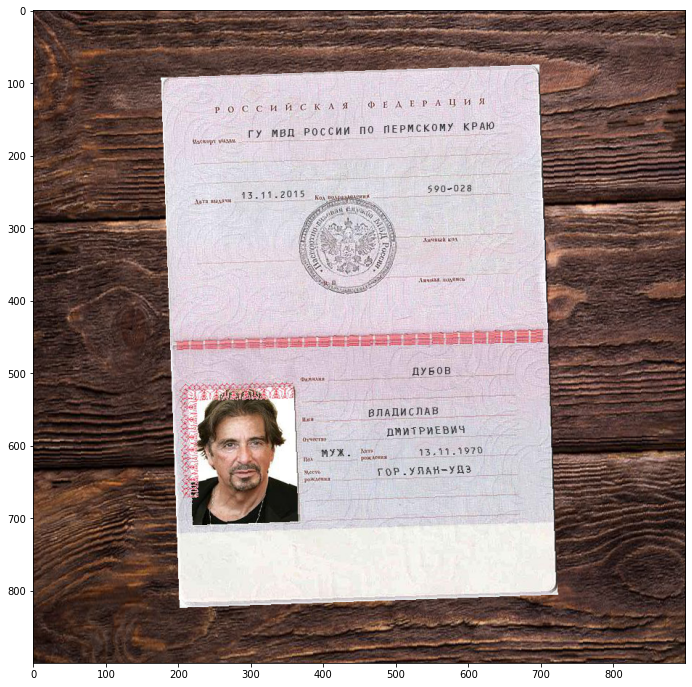

In [ ]:
passport = PIL.Image.open(PREFIX + f"dataset/images/passport{np.random.randint(400, 1000)}.jpg")
rotated = pt.crop_rotate(backs[0], passport, 2)
plt.figure(figsize=(12, 12))
plt.imshow(rotated)

rotated = rotated.resize((224, 224))
rotated = np.array(rotated)

In [ ]:
rotated_np = np.array([[
                    rotated[:, :, 0].reshape(rotated.shape[0], rotated.shape[1]), 
                    rotated[:, :, 1].reshape(rotated.shape[0], rotated.shape[1]), 
                    rotated[:, :, 2].reshape(rotated.shape[0], rotated.shape[1])
                ]])
x_test = torch.from_numpy(rotated_np).type(torch.FloatTensor)
train_gen.get_prediction(np.array(model(x_test).detach()).argmax())

2.0

## MobileNet

In [29]:
from torchvision.models.mobilenet import mobilenet_v2

In [30]:
mobile_net = mobilenet_v2(pretrained=True)
mobile_net.classifier[1] = torch.nn.Linear(in_features=mobile_net.classifier[1].in_features, out_features=61)

optimizer = optim.Adam(params=mobile_net.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [33]:
mobile_net.eval()
mobile_net = mobile_net.to(device)
criterion = criterion.to(device)

In [34]:
pt.count_parameters(mobile_net)

2302013

In [ ]:
Info.append({"Loss": [], "L1": [], "Time": [], "Parameters": 0})
Info[-1]["Parameters"] = pt.count_parameters(mobile_net)

preprocess = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

EPOCHS = 30

best_valid_loss = float('inf')
train_gen = pt.Generator(n_classes=61, batch_size=32, preprocessor=preprocess)
valid_gen = pt.Generator(n_classes=61, batch_size=32, preprocessor=preprocess)

for epoch in range(EPOCHS):

    train_gen.initialize(backs, images[:300])
    valid_gen.initialize(backs, images[300:500])

    start_time = time.monotonic()

    train_loss, train_acc = pt.train(
        mobile_net, 
        train_gen, 
        optimizer, 
        criterion, 
        device
    )
    
    valid_loss, valid_acc, l1_loss = pt.evaluate(
        mobile_net, 
        valid_gen, 
        criterion, 
        device
    )

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(mobile_net.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    Info[-1]["Loss"].append(valid_loss)
    Info[-1]["L1"].append(l1_loss)
    Info[-1]["Time"].append(end_time - start_time)

    epoch_mins, epoch_secs = pt.epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | Val. L1: {l1_loss*1:.2f}%')

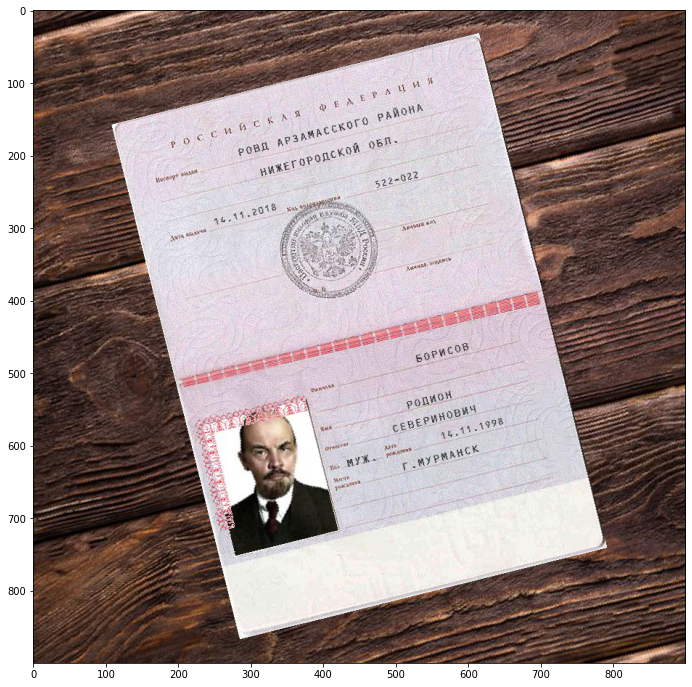

In [ ]:
passport = PIL.Image.open(PREFIX + f"dataset/images/passport{np.random.randint(1000)}.jpg")
rotated = pt.crop_rotate(backs[0], passport, 14)
plt.figure(figsize=(12, 12))
plt.imshow(rotated)

rotated = rotated.resize((224, 224))
rotated = np.array(rotated)

In [ ]:
rotated_np = np.array([[
                    rotated[:, :, 0].reshape(rotated.shape[0], rotated.shape[1]), 
                    rotated[:, :, 1].reshape(rotated.shape[0], rotated.shape[1]), 
                    rotated[:, :, 2].reshape(rotated.shape[0], rotated.shape[1])
                ]])
x_test = preprocess(torch.from_numpy(rotated_np).type(torch.FloatTensor))
np.array(mobile_net(x_test).detach()).argmax() - 30

14

In [ ]:
test_gen = pt.Generator(backs, images[400:], n_classes=30, batch_size=32)
pt.evaluate(mobile_net, test_gen, criterion, device)


## Графики

In [40]:
labels = ["1 conv", "2 conv", "mobile net"]
l1_loss = []
times = []

from dataclasses import field
with open(PREFIX + "models_info.txt", "r") as file:
    for line in file:
        if line.startswith("L1"):
            loss = list(line[2:].strip('[]\n').split(", "))
            if len(loss) > 1:
                l1_loss.append(list(map(float, loss)))
        if line.startswith("Time"):
            times_ = list(line[4:].strip('[]\n').split(", "))
            if len(times_) > 1:
                times.append(list(map(float, times_)))

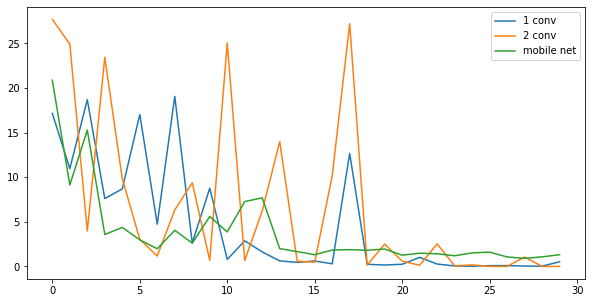

In [41]:
plt.figure(figsize=(10, 5))

for i, label in enumerate(labels):
    plt.plot(np.arange(len(l1_loss[i])), l1_loss[i], label=label)
plt.legend()
plt.show()

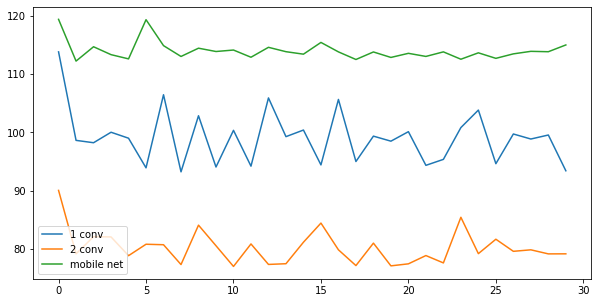

In [42]:
plt.figure(figsize=(10, 5))

for i, label in enumerate(labels):
    plt.plot(np.arange(len(time[i])), time[i], label=label)
plt.legend()
plt.show()